In [1]:
import os
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import random
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [2]:
H, W = 224, 224
BATCH_SIZE = 64

In [3]:
image_paths = []
image_labels = []
glioma_count = menin_count = tumor_count = 0

for dirname, _, filenames in os.walk('/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Brain Cancer/'):
    for filename in filenames:
        path = os.path.join(dirname, filename)
        image_paths.append(path)
        if 'brain_glioma' in filename:
            image_labels.append(0)
            glioma_count += 1
        elif 'brain_menin' in filename:
            image_labels.append(1)
            menin_count += 1
        else:
            image_labels.append(2)
            tumor_count += 1

#Shuffle
combined = list(zip(image_paths, image_labels))
random.shuffle(combined)
image_paths, image_labels = zip(*combined)
image_paths = list(image_paths)
image_labels = list(image_labels)

print(image_paths[:5], '\n')
print(image_labels[:5], '\n')

print("Image count:", len(image_paths))
print("Brain glioma count:", glioma_count)
print("Brain menin count:", menin_count)
print("Brain tumor count:", tumor_count)

print("Image size:", Image.open(image_paths[0]).size)
print("Image mode:", Image.open(image_paths[0]).mode)

['/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Brain Cancer/brain_menin/brain_menin_3699.jpg', '/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Brain Cancer/brain_tumor/brain_tumor_1490.jpg', '/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Brain Cancer/brain_tumor/brain_tumor_0201.jpg', '/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Brain Cancer/brain_glioma/brain_glioma_4288.jpg', '/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Brain Cancer/brain_menin/brain_menin_2714.jpg'] 

[1, 2, 2, 0, 1] 

Image count: 15000
Brain glioma count: 5000
Brain menin count: 5000
Brain tumor count: 5000
Image size: (512, 512)
Image mode: RGB


In [4]:
#train, val, test = 80%, 10%, 10%
train_paths, temp_paths, train_labels, temp_labels = train_test_split(image_paths, image_labels, test_size=0.2, stratify=image_labels)
val_paths, test_paths, val_labels, test_labels = train_test_split(temp_paths, temp_labels, test_size=0.5, stratify=temp_labels)

print('Train size:', len(train_paths))
print('val size:', len(val_paths))
print('Test size:', len(test_paths))

Train size: 12000
val size: 1500
Test size: 1500


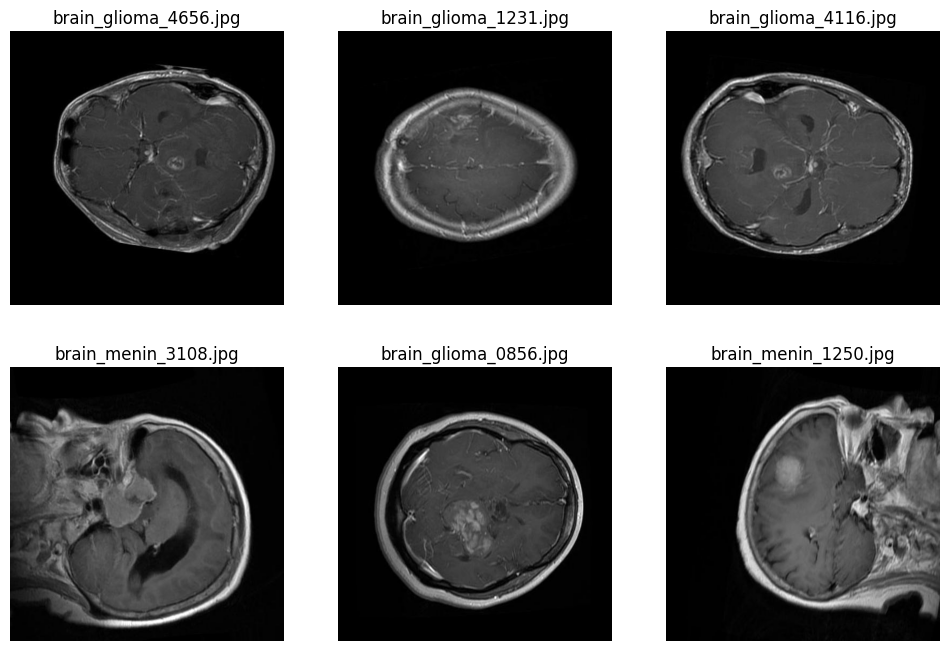

In [5]:
sample_images = random.sample(train_paths, 6)
plt.figure(figsize=(12, 8))

for i, img_path in enumerate(sample_images):
    img = Image.open(img_path)
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(os.path.basename(img_path), fontsize=12)
    plt.axis('off')

plt.show()

In [6]:
# Calculate Mean and Standard Deviation of the training set
transform = transforms.Compose([
    transforms.Resize((H, W)),
    transforms.ToTensor()
])

mean = 0.
std = 0.
n = 0

for path in tqdm(train_paths):
    img = Image.open(path).convert('RGB')
    img = transform(img)  # shape: [3, H, W]
    mean += img.mean(dim=[1,2])
    std += img.std(dim=[1,2])
    n += 1

mean /= n
std /= n

print("Mean:", mean)
print("Std:", std)

100%|██████████| 12000/12000 [02:11<00:00, 91.06it/s]

Mean: tensor([0.1539, 0.1539, 0.1539])
Std: tensor([0.1642, 0.1642, 0.1642])


In [7]:
train_transform = transforms.Compose([
    transforms.Resize((H, W)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])

val_transform = transforms.Compose([
    transforms.Resize((H, W)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])

test_transform = transforms.Compose([
    transforms.Resize((H, W)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])

In [8]:
class ImageDataset(Dataset):
    def __init__(self, image_paths, image_labels, transform=None):
        self.image_paths = image_paths
        self.image_labels = image_labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img_label = self.image_labels[idx]

        img = Image.open(img_path).convert('RGB')
        
        if self.transform:
            img = self.transform(img)

        return img, label

train_dataset = ImageDataset(train_paths, train_labels, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) 

val_dataset = ImageDataset(val_paths, val_labels, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True) 

test_dataset = ImageDataset(test_paths, test_labels, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True) 